In [1]:
!pip install pathlib
!pip install timm
!pip install shap


[notice] A new release of pip is available: 23.1.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.22.4 which is incompatible.
tensorflow-gpu 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.12.0 which is incompatible.
tensorflow-gpu 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.3 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.12.1 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.12.0 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.5.0 which is incompatible.

[notice] A new release of pip is available: 23.1.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached numpy-1.22.4-cp310-cp310-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [1]:
!nvidia-smi

Thu Dec  7 16:08:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8     1W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install numpy==1.23.5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
import seaborn
import zipfile
import os
import requests 
from pathlib import Path
import random
import io
from sklearn.model_selection import train_test_split
import cv2 as cv
from PIL import Image as PImage
import timm
import shutil
import seaborn as sns
from tqdm.notebook import tqdm
from timeit import default_timer as Timer

%matplotlib inline

c:\Users\ACER NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.11) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\ACER NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(f'numpy version: {np.__version__}')
print(f'pytorch verion: {torch.__version__}')

numpy version: 1.23.5
pytorch verion: 1.13.1+cu116


In [4]:
#unzip the data
file_path = "pnemonia.zip"
with zipfile.ZipFile(file_path,'r') as zip_ref:
    path_to_file = 'pneumonia_unzipped'
    if not os.path.exists(path_to_file):
        os.mkdir(path_to_file)
    extract_path = path_to_file
    zip_ref.extractall(extract_path)

In [5]:
!dir "pneumonia_unzipped"

 Volume in drive D is New Volume
 Volume Serial Number is B094-31B3

 Directory of d:\my final year projects\data\pneumonia project\pneumonia_unzipped

30/11/2023  23:01    <DIR>          .
03/12/2023  21:36    <DIR>          ..
30/11/2023  20:35    <DIR>          test
30/11/2023  20:35    <DIR>          train
30/11/2023  20:36    <DIR>          val
               0 File(s)              0 bytes
               5 Dir(s)  31,899,455,488 bytes free


In [6]:
!dir "pneumonia_unzipped\train"

 Volume in drive D is New Volume
 Volume Serial Number is B094-31B3

 Directory of d:\my final year projects\data\pneumonia project\pneumonia_unzipped\train

30/11/2023  20:35    <DIR>          .
30/11/2023  23:01    <DIR>          ..
30/11/2023  20:35    <DIR>          normal
03/12/2023  21:40    <DIR>          opacity
               0 File(s)              0 bytes
               4 Dir(s)  31,899,455,488 bytes free


In [3]:
#create a functionto set all seed
def seed_all(seed = 1234):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


In [4]:
#explore the dataset
DIR = "pneumonia_unzipped"
DIR_TRAIN = "pneumonia_unzipped/train/"
DIR_TEST = "pneumonia_unzipped/test/"
DIR_VAL = "pneumonia_unzipped/val/"
classes = os.listdir(DIR_TRAIN)
print(f'Total classes: {len(classes)}')
train_count  = 0
test_count = 0
val_count = 0
classes_df = list()
for _class in classes:
    class_dict = dict()
    train_len = len([i for i in os.listdir(DIR_TRAIN + _class)])
    test_len = len([i for i in os.listdir(DIR_TEST + _class)])
    val_len = len([i for i in os.listdir(DIR_VAL + _class)])
    train_count += train_len
    test_count += test_len
    val_count += val_len
    class_dict.update({'classer':_class,'Train':train_len,'Test':test_len,'val':val_len})
    classes_df.append(class_dict)
print(f'Total train images: {train_count}')
print(f'Total test images: {test_count}')
print(f'Total val images: {val_count}')
Data = pd.DataFrame(classes_df).set_index('classer')

Total classes: 2
Total train images: 4192
Total test images: 624
Total val images: 1040


In [5]:
Data

,Train,Test,val
classer,,,
normal,1082,234,267
opacity,3110,390,773


In [6]:
#plot the data distribution
classes_df = pd.DataFrame(classes_df)
def dataset_plotter(datasets,column_name):
    sns.set(style = 'whitegrid')
    plt.figure(figsize=(9,5))
    data_to_plot = datasets.sort_values(by = column_name,ascending = False)
    print(data_to_plot)
    sns.barplot(data=data_to_plot,y = 'classer',x = column_name ,orient='h',palette='dark',)
    plt.xlabel('numbe of images in dataset')
    plt.ylabel('class name')
    plt.title(f'pneumonia class vs amount of data in {column_name}')
    plt.show()

   classer  Train  Test  val
1  opacity   3110   390  773
0   normal   1082   234  267


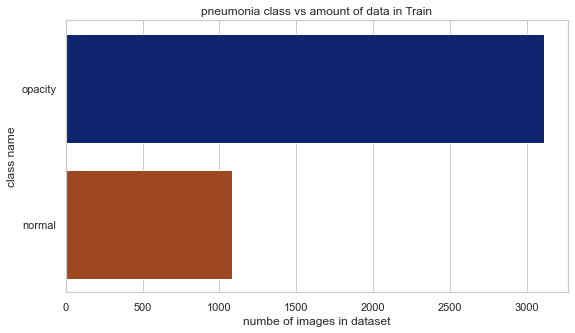

In [7]:
dataset_plotter(classes_df,'Train')

class is very imbalanced

   classer  Train  Test  val
1  opacity   3110   390  773
0   normal   1082   234  267


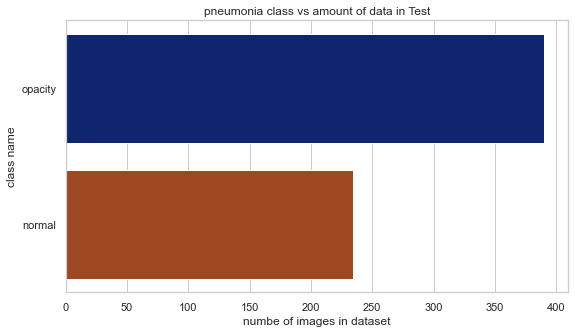

In [9]:
dataset_plotter(classes_df,'Test')

   classer  Train  Test  val
1  opacity   3110   390  773
0   normal   1082   234  267


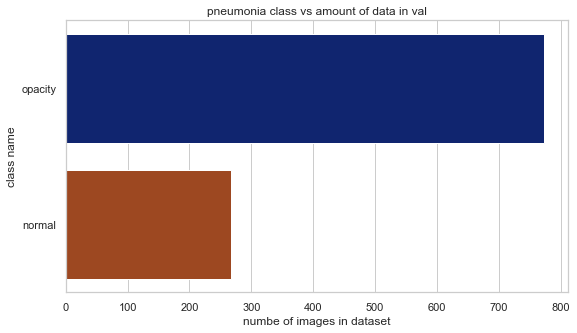

In [10]:
dataset_plotter(classes_df,'val')

**create a numpy array of file**

In [8]:
class LoadDataset():
    def __init__(self,data_path:str,img_size:int = 100,resize:bool = True) -> None:
        self.d_path = data_path
        self.resize = resize
        self.image_size = img_size
        self.normal = data_path + os.listdir(data_path)[0]
        self.opacity = data_path + os.listdir(data_path)[1]
        self.labels = {k:v for (k,v) in zip([self.normal,self.opacity],list(range(len(os.listdir(DIR_TRAIN)))))}
        print(self.labels)
        self.training_data = []
        self.total_labels = []
        self.normal_count = 0
        self.opacity_count = 0
    def create_dataset(self,rebuild = True):
        total_images = 0
        if rebuild:
            for key in self.labels:
                print(key)
                for img_file in tqdm(os.listdir(key)):
                    try:
                        path = os.path.join(key,img_file)
                        image = cv.imread(path)
                        if self.resize:
                            image = cv.resize(image,(self.image_size,self.image_size))
                        image = np.array(image)
                        self.training_data.append([image,int(self.labels[key])])
                        if key == self.normal:
                            self.normal_count += 1
                            total_images += 1
                        elif key == self.opacity:
                            self.opacity_count += 1
                            total_images += 1
                    except Exception as e:
                        print(f'Error: {e}')
            np.random.shuffle(self.training_data)
            self.total_labels = [trd[-1] for trd in self.training_data]
            print(f'Total amount of labels: {len(self.total_labels)}')
            pather = f"D:/my final year projects/data/pneumonia project/tensorified_{self.d_path.split('/')[-2]}_data/"
            if os.path.exists(pather):
                print('path initially exists')
                shutil.rmtree(pather)
                os.mkdir(pather)
            else:
                os.mkdir(pather)
            if self.resize:
                pth = f"D:/my final year projects/data/pneumonia project/tensorified_{self.d_path.split('/')[-2]}_data/pneumonia_images_{self.image_size}_{self.d_path.split('/')[-2]}.npy"
            else:
                pth = f"D:/my final year projects/data/pneumonia project/tensorified_{self.d_path.split('/')[-2]}_data/pneumonia_images_actualsize_{self.image_size}_{self.d_path.split('/')[-2]}.npy"
            print(len(self.training_data))
            np.save(pth,self.training_data)
            print(f'---Normal: {self.normal_count}')
            print(f'---Opacity: {self.opacity_count}')
            print(f'Total images is {total_images}')
            print('done tensorifying data to numpy version...')
            return pth,self.total_labels
        else:
            print('rebuild set to False,set rebuild to rebuild dataset')   


In [9]:
def tensorfier(dataset,img_size,resize):
    data = LoadDataset(dataset,img_size,resize)
    data_path,total_labels = data.create_dataset()
    print(f'Total labels is {total_labels},to be used in solving the problem of imbalance')
    #assert len(total_labels) == 4190,'something is not right with the lenght of the total labels,fix it...'
    print(len(total_labels))
    print(f'path to np file is {data_path}')
    return data_path,total_labels
def load_tensored_data(data_path):
    dataset = np.load(data_path,allow_pickle=True)
    return dataset

shape of the image is (1200, 1200, 3)


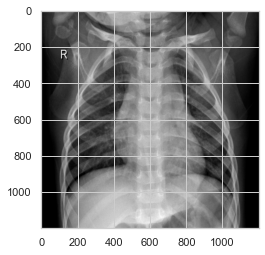

In [10]:
img  = cv.imread("D:/my final year projects/data/pneumonia project/pneumonia_unzipped/train/normal/IM-0117-0001.jpeg")
img = cv.resize(img,(1200,1200))
print(f'shape of the image is {img.shape}')
plt.imshow(img)

In [11]:
#call the tensorify function to call the loaddataset class
train_dataset_path,total_labels = tensorfier(DIR_TRAIN,64,True)#set back to 224 after first training

{'pneumonia_unzipped/train/normal': 0, 'pneumonia_unzipped/train/opacity': 1}
pneumonia_unzipped/train/normal


  0%|          | 0/1082 [00:00<?, ?it/s]

pneumonia_unzipped/train/opacity


  0%|          | 0/3110 [00:00<?, ?it/s]

Total amount of labels: 4192
path initially exists
4192


c:\Users\ACER NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


---Normal: 1082
---Opacity: 3110
Total images is 4192
done tensorifying data to numpy version...
Total labels is [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1

In [12]:
train_dataset = load_tensored_data(train_dataset_path)

In [13]:
train_dataset

array([[array([[[106, 106, 106],
                [125, 125, 125],
                [143, 143, 143],
                ...,
                [ 84,  84,  84],
                [ 83,  83,  83],
                [ 86,  86,  86]],

               [[108, 108, 108],
                [110, 110, 110],
                [140, 140, 140],
                ...,
                [ 70,  70,  70],
                [ 85,  85,  85],
                [ 81,  81,  81]],

               [[109, 109, 109],
                [114, 114, 114],
                [131, 131, 131],
                ...,
                [ 85,  85,  85],
                [ 85,  85,  85],
                [ 83,  83,  83]],

               ...,

               [[  1,   1,   1],
                [ 22,  22,  22],
                [ 59,  59,  59],
                ...,
                [ 36,  36,  36],
                [ 10,  10,  10],
                [  0,   0,   0]],

               [[  3,   3,   3],
                [ 23,  23,  23],
                [ 56,  56,  5

In [14]:
len(train_dataset)

4192

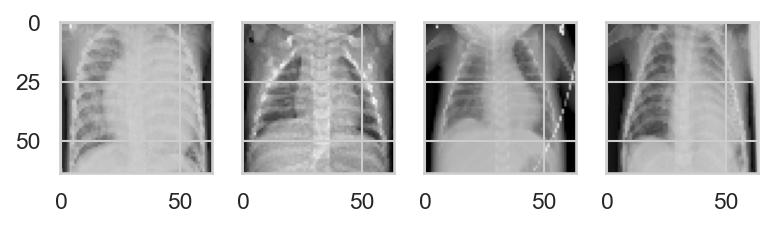

In [15]:
figure, axes = plt.subplots(1,4, dpi=150, sharey=True)
axes[0].imshow(train_dataset[np.random.randint(0,len(train_dataset))][0])
axes[1].imshow(train_dataset[np.random.randint(0,len(train_dataset))][0])
axes[2].imshow(train_dataset[np.random.randint(0,len(train_dataset))][0])
axes[3].imshow(train_dataset[np.random.randint(0,len(train_dataset))][0])

In [16]:
#create a dictionary of class names
class_labels_dict = {k:v for (k,v) in zip(list(range(2)),['normal','opacity'])}
class_labels_dict

{0: 'normal', 1: 'opacity'}

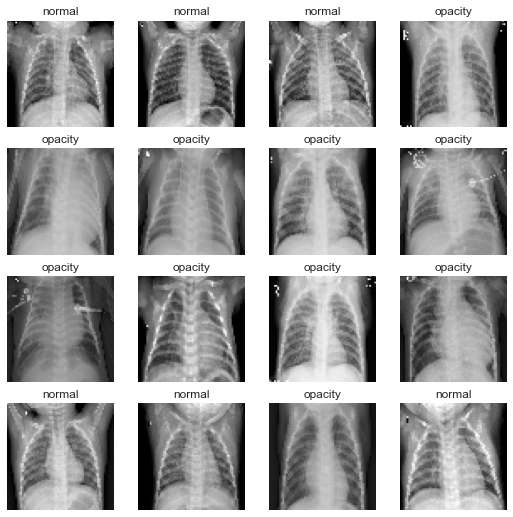

In [17]:
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows,cols = 4,4
for i in range(1,rows * cols + 1):
  random_idx = torch.randint(0,len(train_dataset),size = [1]).item()
  img,label = train_dataset[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap = 'gray')
  plt.title(class_labels_dict[label])
  plt.axis(False);


In [18]:
val_dataset_path,val_labels = tensorfier(DIR_VAL,64,True)

{'pneumonia_unzipped/val/normal': 0, 'pneumonia_unzipped/val/opacity': 1}
pneumonia_unzipped/val/normal


  0%|          | 0/267 [00:00<?, ?it/s]

pneumonia_unzipped/val/opacity


  0%|          | 0/773 [00:00<?, ?it/s]

Total amount of labels: 1040
path initially exists
1040
---Normal: 267
---Opacity: 773
Total images is 1040
done tensorifying data to numpy version...
Total labels is [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1

In [19]:
val_dataset = load_tensored_data(val_dataset_path)

In [20]:
test_dataset_path,test_labels = tensorfier(DIR_TEST,28,True)

{'pneumonia_unzipped/test/normal': 0, 'pneumonia_unzipped/test/opacity': 1}
pneumonia_unzipped/test/normal


  0%|          | 0/234 [00:00<?, ?it/s]

pneumonia_unzipped/test/opacity


  0%|          | 0/390 [00:00<?, ?it/s]

Total amount of labels: 624
path initially exists
624
---Normal: 234
---Opacity: 390
Total images is 624
done tensorifying data to numpy version...
Total labels is [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1

c:\Users\ACER NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [21]:
test_dataset = load_tensored_data(test_dataset_path)

creating custom datasets for problem

In [22]:
class PneumoniaDataset(Dataset):
    def __init__(self,loaded_dataset,transforms = None):
        self.loaded_dataset = loaded_dataset
        self.transforms = transforms
    def __len__(self):
        return len(self.loaded_dataset)
    def __getitem__(self,idx):
        image = self.loaded_dataset[idx][0] / 255
        label = torch.tensor(int(self.loaded_dataset[idx][1]))
        if self.transforms:
            image = self.transforms(image)
        return (image,label)

In [23]:
batch_size = 32
def create_data_loaders(dataset,dataset_cat:str = 'Train',batch_size:int = batch_size,total_labels:list = None):
    general_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2,hue = .1,saturation = .2),
        transforms.RandomPerspective(0.2, 0.2),
        transforms.Normalize(mean= [0.485, 0.456, 0.406]
                            ,std= [0.229, 0.224, 0.225]),
    ])
    if dataset_cat.lower() == 'Test'.lower():
        print('creating test data loader')
        transformations = transforms.Compose([
            transforms.ToTensor()
        ])
        test_set = PneumoniaDataset(dataset,transforms=transformations)
        test_loader = DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)
        print('done creating test dataset...')
        return(test_loader,test_set)
    elif dataset_cat.lower() == 'Train'.lower():
        print('creating train loader')
        transformations = transforms.Compose([
            transforms.ToTensor()
        ])
        train_set = PneumoniaDataset(dataset,transforms=transformations)
        #print('lenght of train_set is: ',len(train_set),'len of total train labels is: ',len(total_labels))
        sampler = WeightedRandomSampler(weights=total_labels,num_samples=len(train_set),replacement=True)
        train_loader = DataLoader(train_set,batch_size=batch_size)
        print('done creating train dataloader...')
        return (train_loader,train_set)
    elif dataset_cat.lower() == 'Val'.lower():
        print('creating val data loaders')
        transformations = transforms.Compose([
            transforms.ToTensor()
        ])
        val_set = PneumoniaDataset(dataset,transforms=transformations)
        print('lenght of val_set is: ',len(val_set))
        sampler = WeightedRandomSampler(weights=total_labels,num_samples=len(val_set),replacement=True)
        val_loader = DataLoader(val_set,batch_size=batch_size,sampler=sampler,)
        print('done creating validation data set...')
        return(val_loader,val_set)


In [24]:
train_dataloader = create_data_loaders(train_dataset,dataset_cat='Train',batch_size=batch_size,total_labels=total_labels)
validation_dataloader = create_data_loaders(val_dataset,dataset_cat='val',batch_size=batch_size,total_labels=val_labels)

creating train loader
done creating train dataloader...
creating val data loaders
lenght of val_set is:  1040
done creating validation data set...


In [25]:
(train_loader,train_set) = train_dataloader
(val_loader,val_set) = validation_dataloader

In [26]:
len(train_loader),len(val_loader)#that is total train batch is 131 ad val is 33

(131, 33)

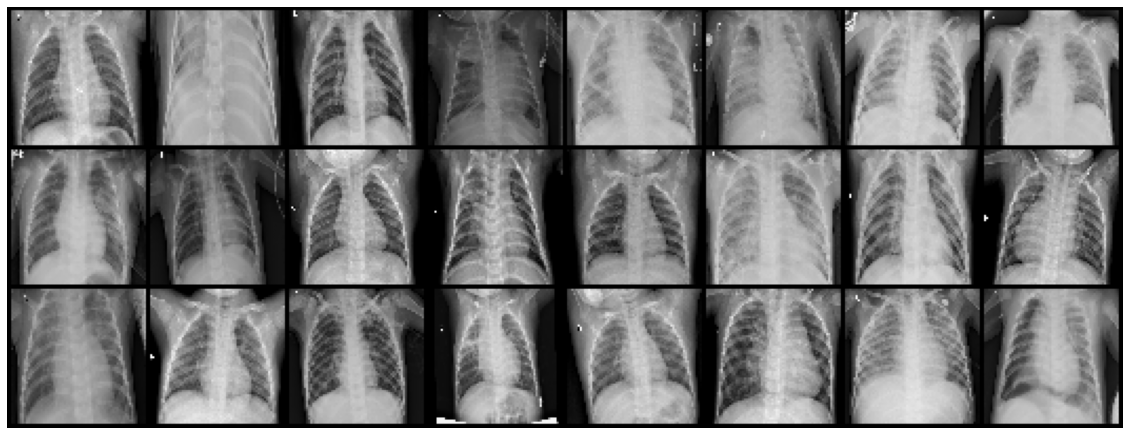

In [27]:
samples, labels = next(iter(train_loader))
plt.figure(figsize=(20,28))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.axis('off')
plt.show()

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
numclass = len(class_labels_dict)
numclass

2

In [30]:
class PneumoniaCNNBL(nn.Module):
    def __init__(self,input_shape:int,output_shape:int,hidden_unit:int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                                out_channels=hidden_unit,
                                kernel_size=3,
                                stride=1,
                                padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_unit,
                out_channels=hidden_unit,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      stride=1,
                      kernel_size=3,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride = 2)
        )
        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit * 13 * 13,
                      out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier_layer(x)
        return x


In [31]:
model_bl_1 = PneumoniaCNNBL(input_shape = 3,hidden_unit = 10,output_shape = numclass).to(device)

In [32]:
model_bl_1

PneumoniaCNNBL(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

In [33]:
from torchinfo import summary
summary(model_bl_1,input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaCNNBL                           [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [34]:
img_batch,img_label = next(iter(train_loader))
img_batch,label_batch = img_batch.type(torch.float).to(device),img_label.type(torch.float).to(device)
r = model_bl_1(img_batch)
r

tensor([[-0.0176,  0.0034],
        [-0.0179,  0.0038],
        [-0.0183,  0.0034],
        [-0.0178,  0.0037],
        [-0.0173,  0.0039],
        [-0.0174,  0.0036],
        [-0.0177,  0.0036],
        [-0.0178,  0.0042],
        [-0.0179,  0.0031],
        [-0.0178,  0.0035],
        [-0.0183,  0.0036],
        [-0.0177,  0.0027],
        [-0.0186,  0.0038],
        [-0.0176,  0.0042],
        [-0.0177,  0.0030],
        [-0.0187,  0.0038],
        [-0.0178,  0.0037],
        [-0.0184,  0.0036],
        [-0.0178,  0.0030],
        [-0.0173,  0.0033],
        [-0.0185,  0.0041],
        [-0.0178,  0.0035],
        [-0.0179,  0.0041],
        [-0.0180,  0.0032],
        [-0.0183,  0.0033],
        [-0.0175,  0.0035],
        [-0.0177,  0.0034],
        [-0.0175,  0.0029],
        [-0.0181,  0.0036],
        [-0.0182,  0.0035],
        [-0.0179,  0.0035],
        [-0.0177,  0.0034]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [35]:
model_bl_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-0.0898,  0.0491, -0.0887],
                        [-0.0226, -0.0782,  0.1277],
                        [-0.1519, -0.0887, -0.0543]],
              
                       [[-0.1157,  0.0182, -0.1901],
                        [ 0.1738, -0.1635,  0.1486],
                        [ 0.0320, -0.0625,  0.1189]],
              
                       [[ 0.0300,  0.1555,  0.0210],
                        [-0.0607,  0.0517, -0.0522],
                        [ 0.0810,  0.1718,  0.1112]]],
              
              
                      [[[-0.0841,  0.1111,  0.0344],
                        [ 0.0977, -0.1173, -0.1905],
                        [-0.0744, -0.1476,  0.1579]],
              
                       [[ 0.0554,  0.0797,  0.0609],
                        [-0.0033,  0.1506, -0.1367],
                        [ 0.0121, -0.1314,  0.0593]],
              
                       [[-0.0663,  0.0590, -0.0401],
                 

In [36]:
#using drbourke's accuracy function from his github account
if Path('helper_function.py').is_file():
    print('file already exists...')
else:
    req = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_function.py','wb') as f:
        f.write(req.content)

file already exists...


In [37]:
from helper_function import accuracy_fn #this for measuring our accuracy

In [38]:
def train_stepper(model:torch.nn.Module,
                  data_loader:torch.utils.data.DataLoader,
                  loss_fn,
                  accuracy_fn,
                  optimizer,
                  device:torch.device = device,
                  verbose:bool = True
                  )->list:
    train_loss = 0
    train_acc = 0
    model.train()
    for batch,(X,y) in enumerate(data_loader):
        #print(f'working with batch: {batch}')
        X,y = X.type(torch.float).to(device),y.type(torch.LongTensor).to(device)
        #y_logits = model(X).squeeze()
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        #train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim = 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim = 1),dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if verbose:
        print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%')
    return [train_loss,train_acc]

In [39]:
def val_stepper(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device = device,
              verbose:bool = True)->list:
    val_loss,val_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for batch,(X_val,y_val) in enumerate(data_loader):
            X,y = X_val.type(torch.float).to(device),y_val.type(torch.LongTensor).to(device)
            val_pred = model(X)
            loss = loss_fn(val_pred,y)
            val_loss += loss.item()
            val_pred_labels = val_pred.argmax(dim = 1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        if verbose:
            print(f'Validation loss: {val_loss:.5f} | Val accuracy: {val_acc:.2f}%')
    return [val_loss,val_acc]

In [40]:
def print_train_time(start:float,end:float,device:torch.device = None):
    total_time = end - start
    print(f'Train time on {device}:{total_time:.3f} seconds...')
    return total_time

In [41]:
def train(model:torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          val_loader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs = 5):
    #seed_all(42)
    results = dict(train_loss = list(),tran_acc = list(),test_loss = list(),test_acc = list())
    train_start_time = Timer()
    metrics_log = []
    for epoch in tqdm(range(epochs)):
        print(f'Epoch: {epoch + 1}\n-----')
        train_details = train_stepper(model=model,
                                    data_loader=train_loader,
                                    loss_fn=loss_fn,
                                    optimizer = optimizer,
                                    accuracy_fn=accuracy_fn)
        validation_details = val_stepper(model=model,
                                        data_loader=val_loader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        train_end_time= Timer()
        print_train_time(start=train_start_time,end=train_end_time)
        metrics_log.append([epoch + 1,train_details[0],train_details[1],validation_details[0],validation_details[1]])
        results['train_loss'].append(train_details[0])
        results['tran_acc'].append(train_details[1])
        results['test_loss'].append(validation_details[0])
        results['test_acc'].append(validation_details[1])
    metrics_path = "metrics_log.npy"
    np.save(metrics_path,metrics_log)
    return results,metrics_path


In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_bl_1.parameters(),lr = 0.1)

In [43]:
seed_all(42)
NUM_EPOCHS = 10
modelbl_result,metrics_path = train(model_bl_1,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-----
Train loss: 0.58399 | Train acc: 0.74%
Validation loss: 0.43167 | Val accuracy: 1.00%
Train time on None:4.565 seconds...
Epoch: 2
-----
Train loss: 0.57655 | Train acc: 0.74%
Validation loss: 0.39903 | Val accuracy: 1.00%
Train time on None:7.401 seconds...
Epoch: 3
-----
Train loss: 0.56501 | Train acc: 0.74%
Validation loss: 0.27993 | Val accuracy: 1.00%
Train time on None:10.359 seconds...
Epoch: 4
-----
Train loss: 0.56350 | Train acc: 0.74%
Validation loss: 0.30741 | Val accuracy: 1.00%
Train time on None:13.245 seconds...
Epoch: 5
-----
Train loss: 0.56372 | Train acc: 0.74%
Validation loss: 0.19541 | Val accuracy: 1.00%
Train time on None:16.354 seconds...
Epoch: 6
-----
Train loss: 0.49418 | Train acc: 0.78%
Validation loss: 0.24697 | Val accuracy: 0.89%
Train time on None:19.204 seconds...
Epoch: 7
-----
Train loss: 0.27189 | Train acc: 0.89%
Validation loss: 0.09250 | Val accuracy: 0.96%
Train time on None:21.750 seconds...
Epoch: 8
-----
Train loss: 0.18663 |

In [44]:
from typing import Dict,List
def plot_loss_curves(results:Dict[str,List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['tran_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))
  plt.figure(figsize = (15,7))
  #loss plot
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label = 'train_loss')
  plt.plot(epochs,test_loss,label = 'test_loss')
  plt.title('Loss')
  plt.xlabel("Epochs")
  plt.legend()

  #accuracy plot
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label = 'train_accuracy')
  plt.plot(epochs,test_accuracy,label = 'test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

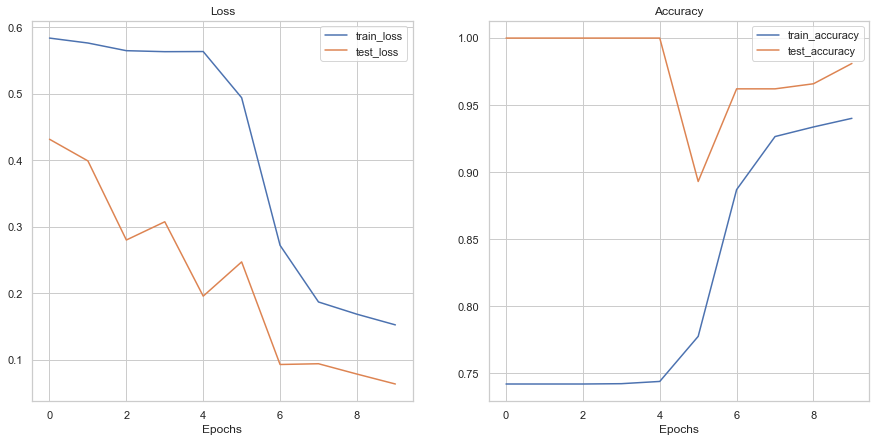

In [45]:
plot_loss_curves(modelbl_result)

In [46]:
import pandas as pd
model_baseline_1_df = pd.DataFrame(modelbl_result)
model_baseline_1_df

,train_loss,tran_acc,test_loss,test_acc
0,0.583988,0.741889,0.431671,1.000000
1,0.576551,0.741889,0.399032,1.000000
2,0.565007,0.741889,0.279932,1.000000
3,0.563504,0.742128,0.307409,1.000000
4,0.563717,0.743798,0.195410,1.000000
5,0.494175,0.777433,0.246971,0.892992
6,0.271892,0.886927,0.092496,0.962121
7,0.186628,0.926527,0.093628,0.962121
8,0.168227,0.933683,0.078077,0.965909
9,0.152145,0.940124,0.063117,0.981061


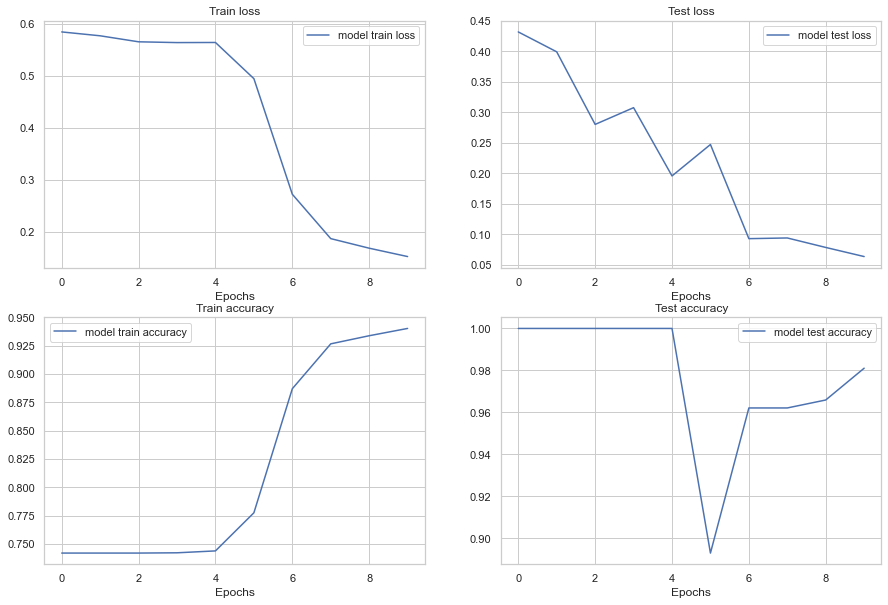

In [47]:
plt.figure(figsize = (15,10))

epochs = range(len(model_baseline_1_df))

plt.subplot(2,2,1)
plt.plot(epochs,model_baseline_1_df['train_loss'],label = 'model train loss')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend();

plt.subplot(2,2,2)
plt.plot(epochs,model_baseline_1_df['test_loss'],label = 'model test loss')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend();

plt.subplot(2,2,3)
plt.plot(epochs,model_baseline_1_df['tran_acc'],label = 'model train accuracy')
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.legend();

plt.subplot(2,2,4)
plt.plot(epochs,model_baseline_1_df['test_acc'],label = 'model test accuracy')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.legend();

test model on image data

In [54]:
import requests

data_path = Path('data_to_test/')
custom_image_path = data_path / 'image_from_net.jpeg'
if not custom_image_path.is_file():
    with open(custom_image_path,'wb') as f:
        req = requests.get('https://intensiveblog.com/wp-content/uploads/2015/09/LL20150909c.jpg')
        print(f'downloading {custom_image_path}')
        f.write(req.content)
else:
    print(f'{custom_image_path} already exists')

downloading data_to_test\image_from_net.jpeg


In [55]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[73, 73, 74,  ..., 25, 24, 24],
         [76, 76, 77,  ..., 25, 24, 24],
         [79, 80, 81,  ..., 29, 26, 26],
         ...,
         [16, 19, 23,  ..., 26, 27, 27],
         [17, 20, 24,  ..., 26, 27, 27],
         [19, 21, 24,  ..., 26, 27, 27]],

        [[73, 73, 74,  ..., 25, 24, 24],
         [76, 76, 77,  ..., 25, 24, 24],
         [79, 80, 81,  ..., 29, 26, 26],
         ...,
         [16, 19, 23,  ..., 26, 27, 27],
         [17, 20, 24,  ..., 26, 27, 27],
         [19, 21, 24,  ..., 26, 27, 27]],

        [[73, 73, 74,  ..., 25, 24, 24],
         [76, 76, 77,  ..., 25, 24, 24],
         [79, 80, 81,  ..., 29, 26, 26],
         ...,
         [16, 19, 23,  ..., 26, 27, 27],
         [17, 20, 24,  ..., 26, 27, 27],
         [19, 21, 24,  ..., 26, 27, 27]]], dtype=torch.uint8)

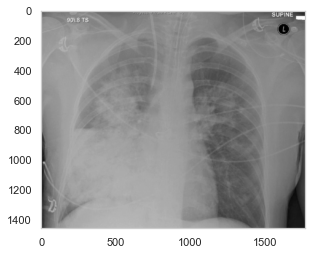

In [61]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.grid(False);

In [62]:
def predictor(custom_image_path:str,
              model:torch.nn.Module,
              class_names:List[str],
              h_w:int = 64,
              device = device):
  custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
  custom_image_transformed = transforms.Compose([transforms.Resize((h_w,h_w))])(custom_image)
  custom_image_transformed = custom_image_transformed.unsqueeze(0)
  model.eval()
  with torch.inference_mode():
    custom_image_pred = model(custom_image_transformed.to(device))
  custom_image_pred_prob = torch.softmax(custom_image_pred,dim = 1)
  custom_image_pred_label = torch.argmax(custom_image_pred_prob,dim = 1)
  plt.imshow(custom_image_transformed.squeeze(0).permute(1,2,0))
  if class_names:
    title = f'pred: {class_names[custom_image_pred_label.cpu()]} | prob: {custom_image_pred_prob.max().cpu():.3f}'
  else:
    title =  f'pred: {custom_image_pred_label} | prob: {custom_image_pred_prob.max().cpu():.3f}'
  plt.title(title)
  plt.axis(False);
  return class_names[custom_image_pred_label]

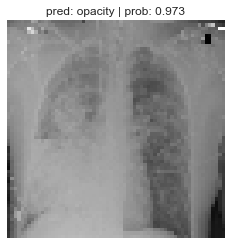

In [65]:
image_pred = predictor(custom_image_path=custom_image_path,
                       class_names=classes,
                       model=model_bl_1,
                       h_w=64,)